In [8]:
import numpy as np
from matplotlib import pyplot as plt
from numpy import linalg as la
from enum import Enum
from numpy import random
%matplotlib inline

In [2]:
class ProgressBar(object):
    
    def __init__(self, total, prefix='', suffix='', decimals=1, length=100, fill='█'):
        """
        Creates terminal progress bar instance.
        @params:
            total      - Required  : total iterations (Int)
            prefix     - Optional  : prefix string (Str)
            suffix     - Optional  : suffix string (Str)
            decimal    - Optional  : positive number of decimals in percent complete (Int)
            length     - Optional  : character length of bar (Int):
            fill       - Optional  : bar fill character (Str)
        """
        self.total = total
        self.prefix = prefix
        self.suffix = suffix
        self.decimals = decimals
        self.length = length
        self.fill = fill


    def print_bar(self, iteration):
        """
        Updates progress bar status.
        @params:
            iteration  - Required  : current iteration (Int)
        """
        percent = ("{0:." + str(self.decimals) + "f}").format(
                        100 * (iteration / float(self.total)))
        filled_length = int(self.length * iteration // self.total)
        bar = self.fill * filled_length + '-' * (self.length - filled_length)

        print('\r{} |{}| {}% {}'.format(self.prefix, bar, percent, self.suffix), end='\r')

        # print a new line on complete
        if iteration == self.total:
            print()


class Id(object):
    """
    ID generator - a singleton class.

    Example:
        ID = Id()
        Id.get()
    """

    class __Id:

        def __init__(self):
            self.generator = self.id_gen()

        def id_gen(self):
            id_ = 0
            while True:
                yield id_
                id_ += 1

        def get(self):
            return next(self.generator)
        
        def reset(self):
            self.generator = self.id_gen()

    instance = None

    def __new__(cls):
        if not Id.instance:
            Id.instance = Id.__Id()
        return Id.instance

    def __getattr__(self, name):
        return getattr(self.instance, name)

    def __setattr__(self, name):
        return setattr(self.instance, name)


TOLERANCE = 1e-15


def vec3D(x, y, z):
    return np.array([x, y, x])

def normalize(x):
    norm = la.norm(x)
    return x / norm if norm > TOLERANCE else vec3D(0.,0.,0.)

def to_log_scale(lin_scaled):
    return 10 * np.log10(lin_scaled) if lin_scaled > TOLERANCE else -np.inf

def to_lin_scale(log_scaled):
    return np.exp(log_scaled / 10)

def power(amplitude):
    return np.abs(amplitude) ** 2

In [3]:
class Shape(object):

    def get_normal(self, surface_point):
        pass
    
    def intersect(self, start, direction):
        return np.inf


class Plane(Shape):
    
    def __init__(self, init_point, normal, reflection=0):
        self.init_point = init_point
        self.normal = normal
        self.reflection = reflection


    def get_normal(self, surface_point):
        return self.normal


    def intersect(self, start, direction):
    
        denom = np.dot(direction, self.normal)
        if np.abs(denom) < 1e-6:
            return np.inf

        d = np.dot(self.init_point - start, self.normal) / denom
        if d < 0:
            return np.inf

        return d

In [4]:
class Ray(object):

    c = 299792458. # speed of light, in mps

    class Type(Enum):
        PRIMARY = 0
        REFLECTED = 1
        REFRACTED = 2
    
    def __init__(self, start, direction, k, type_=Type.PRIMARY):

        self.id = Id().get()
        self.type = type_

        # Geometrical properties
        self.start = start
        self.direction = direction
        self.end = None
        self.length = -1

        # Propagation parameters
        self.att = 0.j
        self.k = k
        self.delay = 0.


    def set_end(self, end):
        self.end = end
        self.length = la.norm(self.end - self.start)


    def attenuation(self, time=0., rspeed=None):
        self.att = .5 / (self.k * self.length) * np.exp(-1j * self.k * self.length)
        return self.att    


    def delay(self):
        self.delay = self.lenght / c
        return self.delay


    def doppler_shift(self, rspeed):
        return .5 / np.pi * self.k * np.dot(self.direction, rspeed)


#     def __str__(self):
#         string = '<{}({}) start={} end={} dir={} len={:.4}; att={:.4}({:.4}) ior={:.4}>'
#         return string.format(self.type.name, self.id, self.start, self.end, 
#                              self.direction, self.length, self.att,
#                              self.cum_att, self.inside)


# class RayNode(object):
    
#     def __init__(self, ray, parent=None, tree=None):
        
#         self.ray = ray
#         self.parent = parent
#         self.reflected = None
#         self.refracted = None
#         self.tree=None
        
#         self.id = ray.id
#         self.depth = parent.depth + 1 if parent else 0
    
#     def __str__(self):
#         reflected_id = str(self.reflected.ray.id) if self.reflected else '.'
#         refracted_id = str(self.refracted.ray.id) if self.refracted else '.'
#         self_id = str(self.ray.id)
#         return '({})<({})>({})'.format(refracted_id, self_id, reflected_id)
    
#     def add_child(self, ray):
#         node = RayNode(ray, parent=self, tree=tree)
        
#         if ray.type is Ray.Type.REFLECTED:
#             self.reflected = node
#         elif ray.type is Ray.Type.REFRACTED:
#             self.refracted = node

#     def view(self):
#         refracted_view = self.refracted.view() if self.refracted else '.'
#         reflected_view = self.reflected.view() if self.reflected else '.'
#         return '[{}]<({})>[{}]'.format(refracted_view, str(self.ray.id), reflected_view)


# class RayTree(object):
    
#     def __init__(self, camera_ray):
#         self.root = RayNode(camera_ray, tree=self)
#         self.rays = dict((camera_ray.id, camera_ray))
#         self.levels = dict((0, camera_ray))
    
#     def __str__(self):
#         return camera_ray.view()


In [5]:
class SceneBuilder(object):
    
    def empty():
        return []


    def build():
        return [Plane([0., 0., 0.], [0., 0., 1.], reflection=0.)]

In [6]:
class RadioRayTracer(object):
    
    def __init__(self, scene, wavelen, k):
        self.scene = scene
        self.wavelen = wavelen
        self.k = k


    def run(self, tx_position, rx_position):
        
        # Compute a line-of-sight component
        direction = normalize(rx_position - tx_position)
        ray = Ray(tx_position, direction, self.k)
        ray.set_end(rx_position)
        
        return ray


In [23]:
class KRayPathloss(object):
    
    c = 299792458. # speed of light, in mps
    
    def __init__(self, scene, freq):
        self.scene = scene
        
        self.wavelen = KRayPathloss.c / freq
        self.k = 2 * np.pi / self.wavelen
        
        self.ray_ = None


    def compute(self, tx_pos, rx_pos, time=0.):

        tracer = RadioRayTracer(self.scene, self.wavelen, self.k)
        self.ray_ = tracer.run(tx_pos, rx_pos)
        att = self.ray_.attenuation()
        
        return att



class KRayWrapper(object):
    
    def __init__(self, scene, freq):
        self.kray = KRayPathloss(scene, freq)


    def _to_1darray(self, d):
        
        if isinstance(d, int) or isinstance(d, float): 
            d = np.array(list(d))
        
        elif isinstance(d, list):
            d = np.array(d)
        
        return d


    def run(self, d, t=None, out='power', log=True):

        d = self._to_1darray(d)
        result = np.zeros(d.shape)

        for i, d_i in enumerate(d):

            att = self.kray.compute(vec3D(0., 0., 5.), vec3D(d_i, 0., .5), t)
            
            if out == 'power':
                power = np.abs(att) ** 2
                result[i] = to_log_scale(power) if log else power

            if out == 'phase':
                result[i] = np.angle(att)

            if out == 'magnitude':
                result[i] = np.abs(att)

            if out == 'attenuation':
                result[i] = att
        
        return result

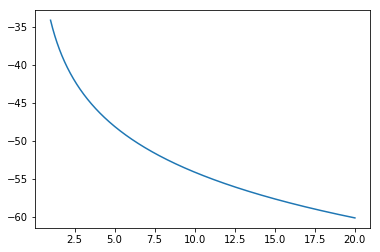

In [25]:
kray = KRayWrapper(SceneBuilder.empty(), 860e6)

distance = np.linspace(1, 20, 1000)
pathloss = kray.run(distance)

plt.figure()
plt.plot(distance, pathloss)
plt.show()

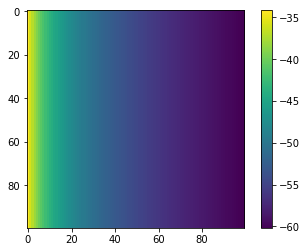

In [47]:
c = 299792458.
f_c = 860e6

wavelen = c / f_c
scene = SceneBuilder.empty()
kray = KRayPathloss(scene, wavelen)

kray_vec = np.vectorize(lambda d, t: kray_wrapper(kray, d, t, out='power'))

distance = np.linspace(1, 20, 100)
time     = np.linspace(1, 20, 100)

dd, tt = np.meshgrid(distance, time)

pathloss = kray_vec(dd, tt)

plt.figure()
plt.imshow(pathloss)
plt.colorbar()
plt.show()